In [14]:
# AlexNet Tensorflow implementation with pre-trained weights
# Paper : https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf
# Ref : https://kratzert.github.io/2017/02/24/finetuning-alexnet-with-tensorflow.html
# For pre-trained weights, Ref : http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

In [1]:
# import necessary libraries
import os
import cv2
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# import class names
from classes import class_names

In [3]:
# placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
rate = tf.placeholder(tf.float32)

In [4]:
# defining function for convolution layer 
def conv(x, filter_height, filter_width, num_filters, stride_y, 
         stride_x, name, padding='SAME', groups=1):
    """
    Adapted from: https://github.com/ethereon/caffe-tensorflow
    """
    # Get number of input channels
    input_channels = int(x.get_shape()[-1])

    # Create lambda function for the convolution
    convolve = lambda i, k: tf.nn.conv2d(i, k,
                                         strides=[1, stride_y, stride_x, 1],
                                         padding=padding)

    with tf.variable_scope(name) as scope:
        # Create tf variables for the weights and biases of the conv layer
        weights = tf.get_variable('weights', shape=[filter_height, filter_width,
                                                    int(input_channels/groups), num_filters])
        biases = tf.get_variable('biases', shape=[num_filters])  

    if groups == 1:
        conv = convolve(x, weights)

    # In the cases of multiple groups, split inputs & weights and
    else:
        # Split input and weights and convolve them separately
        input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
        weight_groups = tf.split(axis=3, num_or_size_splits=groups, value=weights)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, weight_groups)]

        # Concat the convolved output together again
        conv = tf.concat(axis = 3, values = output_groups)

    # Add biases 
    bias = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape().as_list())

    # Apply relu function
    relu = tf.nn.relu(bias, name = scope.name)

    return relu

In [5]:
# defining function for fully-connected layer
def fc(x, num_in, num_out, name, relu=True):

    with tf.variable_scope(name) as scope:
        # Create tf variables for the weights and biases
        weights = tf.get_variable('weights', shape=[num_in, num_out], trainable=True)
        biases = tf.get_variable('biases', [num_out], trainable=True)

        # Matrix multiply weights and inputs and add bias
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)

        if relu == True:
            # Apply ReLu non linearity
            relu = tf.nn.relu(act)      
            return relu
        else:
            return act 

In [6]:
# defining function for maxpooling
def max_pool(x, filter_height, filter_width, stride_y,
             stride_x, name, padding='SAME'):

    return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1],
                          strides = [1, stride_y, stride_x, 1],
                          padding = padding, name = name) 

# defining function for local response normalisation
def lrn(x, radius, alpha, beta, name, bias=1.0):

    return tf.nn.local_response_normalization(x, depth_radius=radius, alpha=alpha,
                                              beta=beta, bias=bias, name=name)  

# defining dropout function
def dropout(x, rate):
    return tf.nn.dropout(x, rate)

In [7]:
# function to build the computational graph of AlexNet
def AlexNet(x, rate):

    # 1st Layer: Conv (w ReLu) -> Pool -> Lrn
    conv1 = conv(x, 11, 11, 96, 4, 4, padding='VALID', name='conv1')
    pool1 = max_pool(conv1, 3, 3, 2, 2, padding='VALID', name='pool1')
    norm1 = lrn(pool1, 2, 2e-05, 0.75, name='norm1')

    # 2nd Layer: Conv (w ReLu) -> Pool -> Lrn with 2 groups
    conv2 = conv(norm1, 5, 5, 256, 1, 1, groups=2, name='conv2')
    pool2 = max_pool(conv2, 3, 3, 2, 2, padding='VALID', name='pool2')
    norm2 = lrn(pool2, 2, 2e-05, 0.75, name='norm2')

    # 3rd Layer: Conv (w ReLu)
    conv3 = conv(norm2, 3, 3, 384, 1, 1, name='conv3')

    # 4th Layer: Conv (w ReLu) splitted into two groups
    conv4 = conv(conv3, 3, 3, 384, 1, 1, groups=2, name='conv4')

    # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
    conv5 = conv(conv4, 3, 3, 256, 1, 1, groups=2, name='conv5')
    pool5 = max_pool(conv5, 3, 3, 2, 2, padding='VALID', name='pool5')

    # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
    flattened = tf.reshape(pool5, [-1, 6*6*256])
    fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
    dropout6 = dropout(fc6, rate)

    # 7th Layer: FC (w ReLu) -> Dropout
    fc7 = fc(dropout6, 4096, 4096, name='fc7')
    dropout7 = dropout(fc7, rate)

    # 8th Layer: FC and return unscaled activations (for tf.nn.softmax_cross_entropy_with_logits)
    fc8 = fc(dropout7, 4096, 1000, relu=False, name='fc8')
    softmax = tf.nn.softmax(fc8)
    
    return softmax

In [8]:
# function to load pretrained weights
def load_initial_weights(skip_layer, session):
    """
    As the weights from http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/ come 
    as a dict of lists (e.g. weights['conv1'] is a list) and not as dict of 
    dicts (e.g. weights['conv1'] is a dict with keys 'weights' & 'biases') we
    need a special load function
    """

    # Load the weights into memory
    weights_dict = np.load('bvlc_alexnet.npy', allow_pickle=True, encoding='bytes').item()

    # Loop over all layer names stored in the weights dict
    for op_name in weights_dict:

        # Check if the layer is one of the layers that should be reinitialized
        if op_name not in skip_layer:
            with tf.variable_scope(op_name, reuse=True):
                # Loop over list of weights/biases and assign them
                # to their corresponding tf variable
                for data in weights_dict[op_name]:
                    # Biases
                    if len(data.shape) == 1:
                        var = tf.get_variable('biases', trainable=False)
                        session.run(var.assign(data))
                    # Weights
                    else:
                        var = tf.get_variable('weights', trainable=False)
                        session.run(var.assign(data))        

In [9]:
# mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

In [10]:
# get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]
# load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))

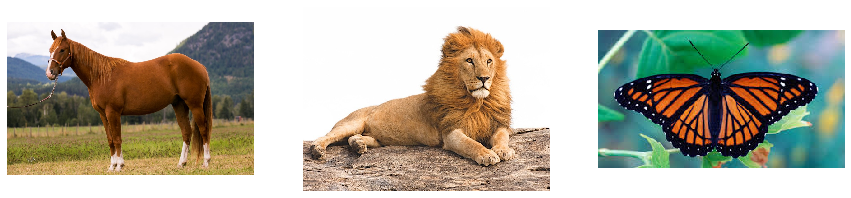

In [11]:
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
sorrel
lion, king of beasts, Panthera leo
monarch, monarch butterfly, milkweed butterfly, Danaus plexippus


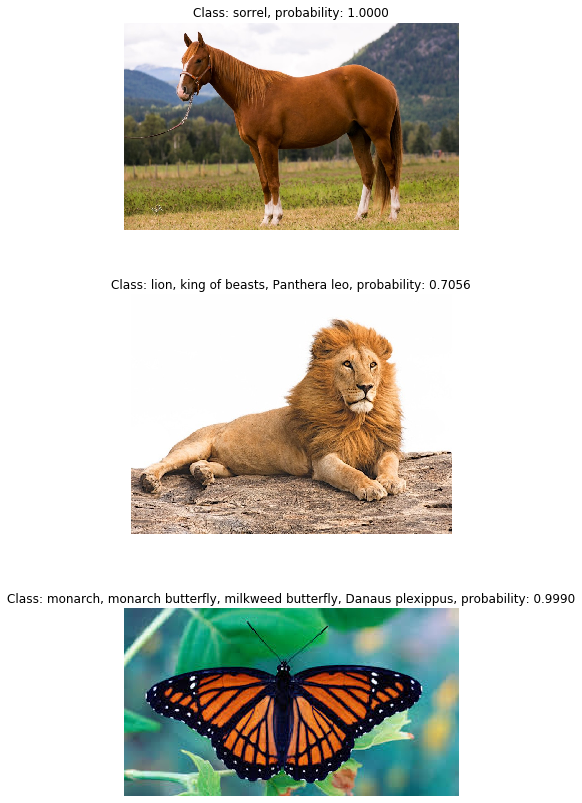

In [12]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model = AlexNet(x, rate)
    load_initial_weights([], sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(6,15))
    
    # Loop over all images
    for i, image in enumerate(imgs):
                    
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))

        # Subtract the ImageNet mean
        img -= imagenet_mean

        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))

        # Run the session and calculate the class probability
        probs = sess.run(model, feed_dict={x: img, rate: 1})

        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        print(class_name)
        # Plot image with class name and prob in the title
        fig2.add_subplot(3,1,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')